# PROJECT 1- ID5059


Loading dataset, working directory and libraries.


In [1]:
setwd('Desktop/Semester1/Software for data analysis /Najmisproject/') 

In [2]:
df<-read.csv('vehicles.csv')
library(tidyverse)
library(ggplot2)
library(splines)
library(car)
library(lmtest)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(maptree)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: zoo
Warning message:
“package ‘zoo’ was built under R version 3.6.1”
Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:


## Cleaning Dataset

Dropping rows having na values in the columns specified.


In [3]:
df_drop<-drop_na(df,c("odometer","condition","year","state","region","state"))

In [4]:
colnames(df_drop)

[1] "id"           "url"          "region"       "region_url"   "price"       
 [6] "year"         "manufacturer" "model"        "condition"    "cylinders"   
[11] "fuel"         "odometer"     "title_status" "transmission" "VIN"         
[16] "drive"        "size"         "type"         "paint_color"  "image_url"   
[21] "description"  "county"       "state"        "lat"          "long"        
[26] "posting_date"

In [5]:
df_under200<-df[df_drop$price<200,]
df_over100k<-df[df_drop$price>100000,]

In [6]:
head(df_under200$manufacturer,10)

[1]           chevrolet audi      hyundai   volvo     volvo     bmw      
 [8] buick     hyundai   gmc      
43 Levels:  acura alfa-romeo aston-martin audi bmw buick cadillac ... volvo

In [7]:
head(df_over100k$manufacturer,10)

[1] chevrolet toyota    chevrolet chevrolet ford      chrysler  ram      
 [8] kia       ford      chevrolet
43 Levels:  acura alfa-romeo aston-martin audi bmw buick cadillac ... volvo

From subsetting the data less than 200 data above, we can see that most of these ads are fake and should be omitted. Furthermore, there are a cars having extremely high prices (above 100K), they might be fake listings. Regardless of their authenticity, the are outliers and could hinder the model's ability to predict by trying to fit those data points.

In [8]:
df_drop<-df_drop%>%
  filter(price>100)%>%
  filter(price<100000)%>%filter(manufacturer!="")
df_drop$type<-replace(df_drop$type,df_drop$type=="","other")
df_drop$condition<-replace(df_drop$condition,df_drop$condition=="","fair")

I have developed a pipeline, that filters data to be with rows only having prices between 200 and 100K. Also, I have dropped rows without manufacturer and type information. 

In [9]:
smp_size <- floor(0.8 * nrow(df_drop))
train_index<-sample(seq_len(nrow(df_drop)),size=smp_size)
train<-df_drop[train_index,]
test<-df_drop[-train_index,]

Splitting the training and testing data above.

## BUILDING A BASIC LINEAR MODEL 
Testing some covariates for checking which gives better R-squared values to use in other models.

In [10]:
simple_model<-lm(price~as.factor(state)+odometer+year+as.factor(type),data=train)
summary(simple_model)


Call:
lm(formula = price ~ as.factor(state) + odometer + year + as.factor(type), 
    data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-36230  -7427  -2572   5399 149408 

Coefficients:
                             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                -1.138e+06  5.113e+03 -222.641  < 2e-16 ***
as.factor(state)al         -2.563e+03  3.103e+02   -8.260  < 2e-16 ***
as.factor(state)ar         -2.068e+03  3.375e+02   -6.126 9.05e-10 ***
as.factor(state)az         -2.260e+03  2.800e+02   -8.072 6.93e-16 ***
as.factor(state)ca         -3.690e+03  2.434e+02  -15.161  < 2e-16 ***
as.factor(state)co         -2.873e+03  2.707e+02  -10.614  < 2e-16 ***
as.factor(state)ct         -6.427e+03  3.065e+02  -20.967  < 2e-16 ***
as.factor(state)dc         -5.648e+03  3.541e+02  -15.952  < 2e-16 ***
as.factor(state)de         -5.378e+03  5.261e+02  -10.222  < 2e-16 ***
as.factor(state)fl         -3.955e+03  2.495e+02  -15.853  < 2e-16 ***
as.factor(state)ga 

In [11]:
prediction<-predict(simple_model,test)
R2 <- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
R2

[1] 0.2995739

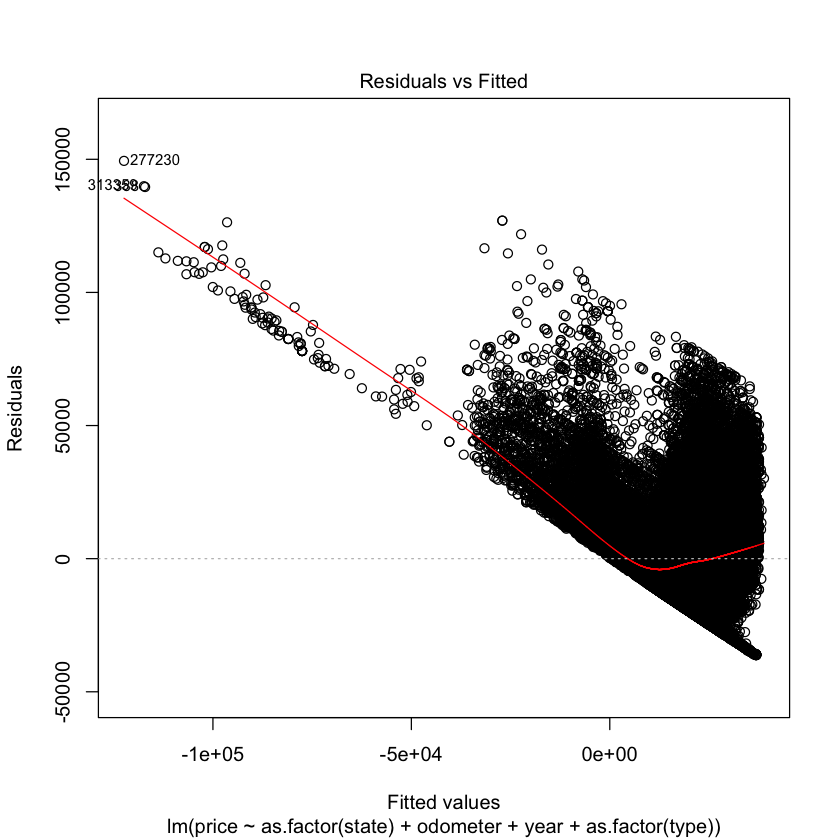

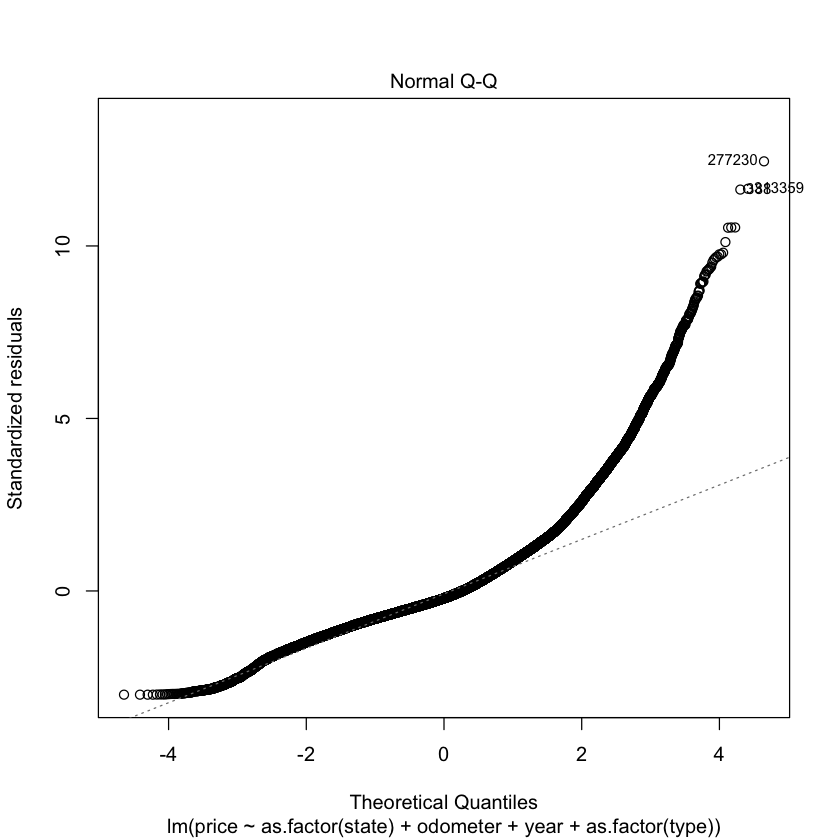

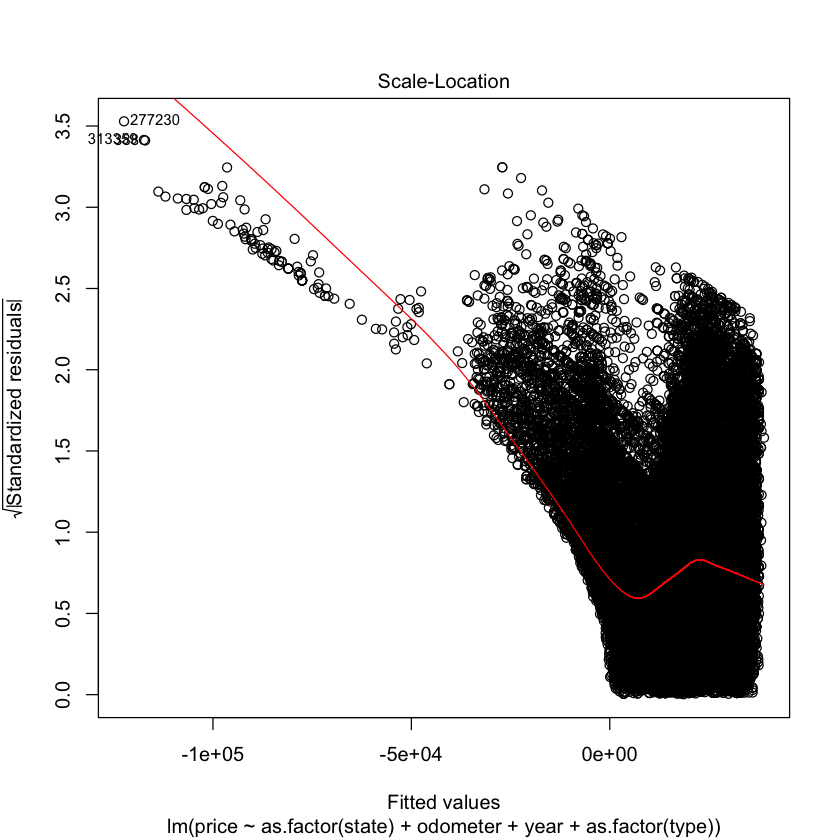

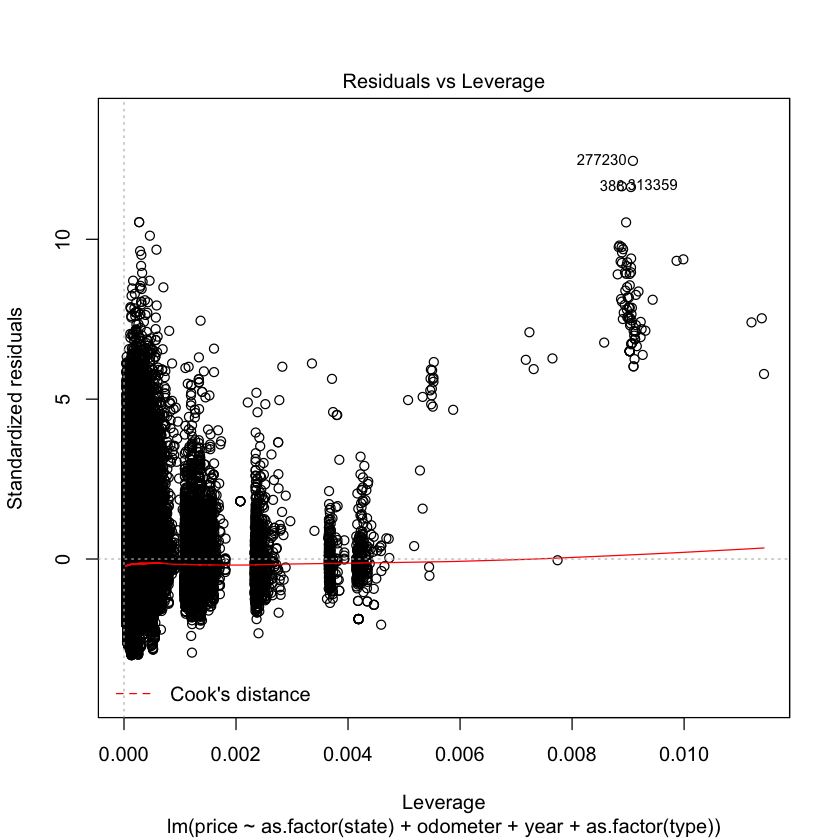

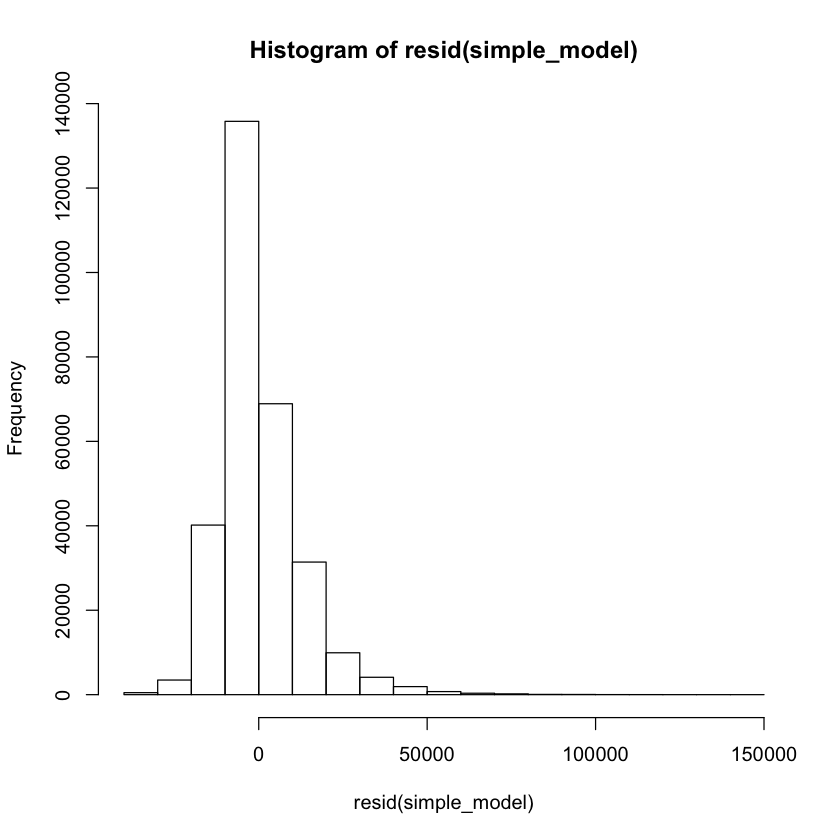

In [12]:
plot(simple_model)
hist(resid(simple_model))

In [13]:
vif(simple_model)

,GVIF,Df,GVIF^(1/(2*Df))
as.factor(state),1.085664,50,1.000822
odometer,1.040108,1,1.019857
year,1.082690,1,1.040524
as.factor(type),1.125092,12,1.004923


### BASIC LINEAR MODEL RESULTS
From the analysis done above, we can see check the assumptions of linear model. Linearity assumption between the covariates seems likely to have been violated (Residuals vs Fitted), the normality assumption looks bad on the q-q plot and the histogram as well (little right skewed), and the homoscadescity assumption (Standardized residuals vs Fitted values) is also violated. Therefore, we need non-linear components to fit the model better. However, we get aproximately 30% of the variance explained by the model, but another problem is that this model gives negative prediction values for the prices. No multicollinearity found.


##  USING SPLINES WITH LINEAR REGRESSION

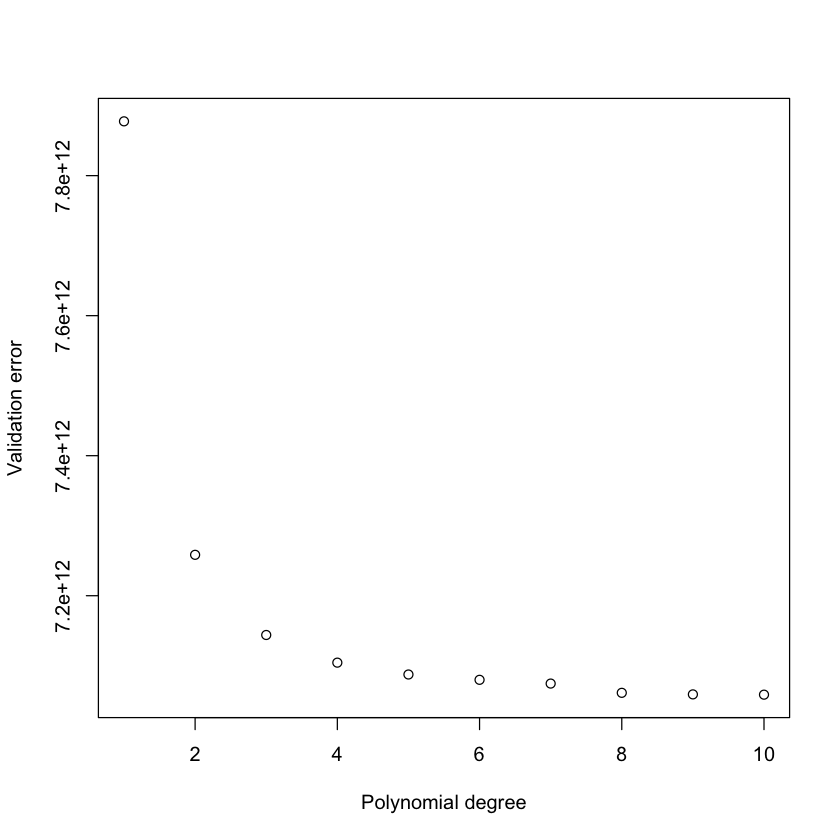

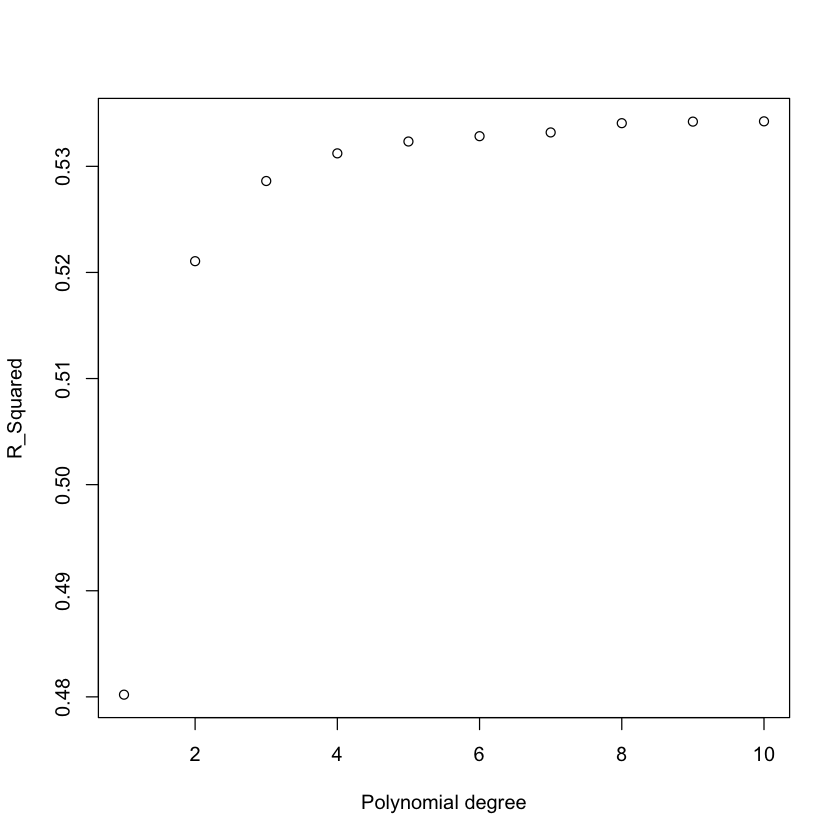

In [14]:
error <- numeric(10)
R_sq<-numeric(10)
for(i in 1:10){
    currentModel<-lm(price~as.factor(state)+
                     bs(odometer,degree = i+1,Boundary.knots = c(min(df_drop$odometer),max(df_drop$odometer)))+
                     bs(year,degree = i+1,Boundary.knots = c(min(train$year),max(train$year)))+
                     as.factor(type),data=train)
    yhat <- predict(currentModel, newdata = test)
    error[i] <- sum((test$price - yhat)^2)
    R_sq[i]<- 1 - (sum((test$price-yhat)^2)/sum((test$price-mean(test$price))^2))
  
}
plot(error, xlab = "Polynomial degree", ylab = "Validation error")  
plot(R_sq, xlab = "Polynomial degree", ylab = "R_Squared")  

From the graph, the validation error and R_squared values, beyond 5 degrees don't improve and therefore there is no use of making the model more complex at the risk of overfitting.

In [15]:
SplineModel<-lm(price~as.factor(state)+
                bs(odometer,degree = 5, Boundary.knots = c(min(df_drop$odometer),max(df_drop$odometer)))+
                bs(year,degree = 5, Boundary.knots = c(min(train$year),max(train$year)))+
                as.factor(type),data=train)
  

In [16]:
yhat<-predict(SplineModel,test)
R<- 1 - (sum((test$price-yhat)^2)/sum((test$price-mean(test$price))^2))
print(R)

[1] 0.5312226


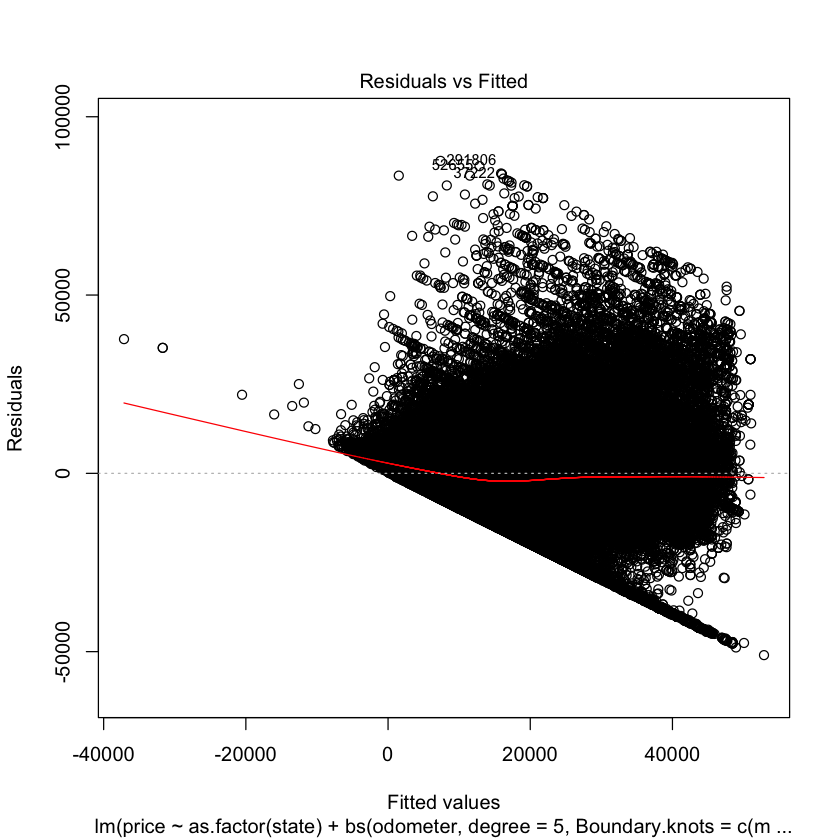

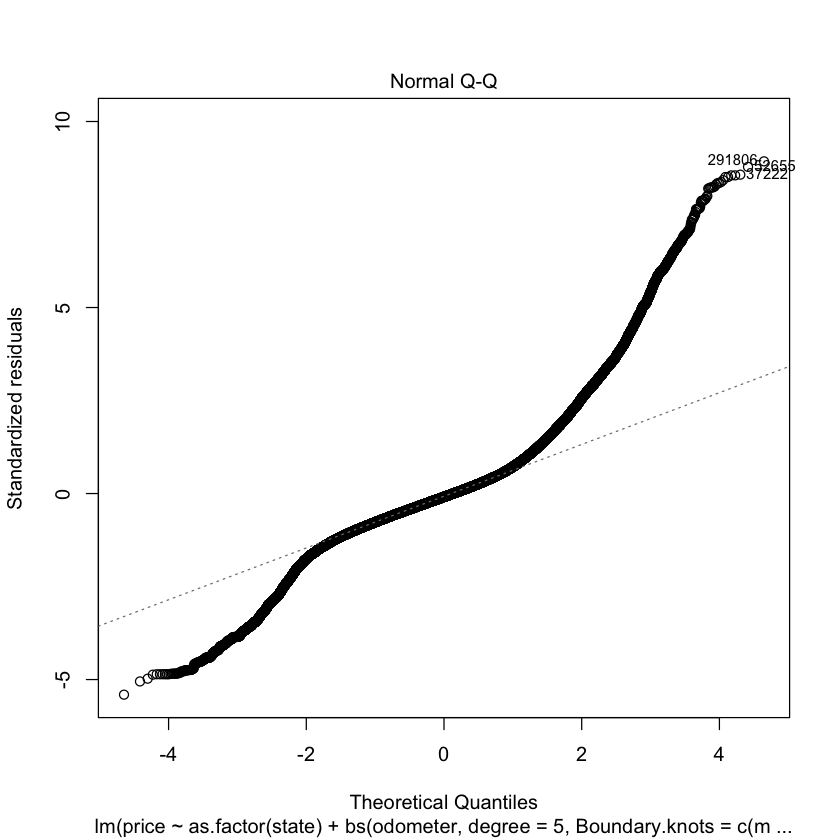

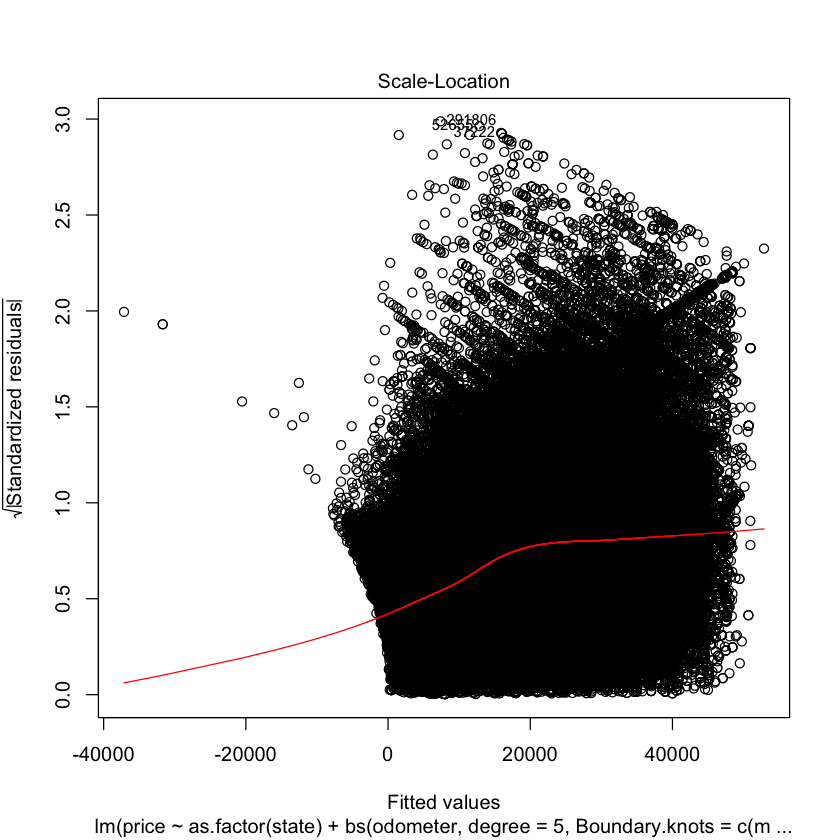

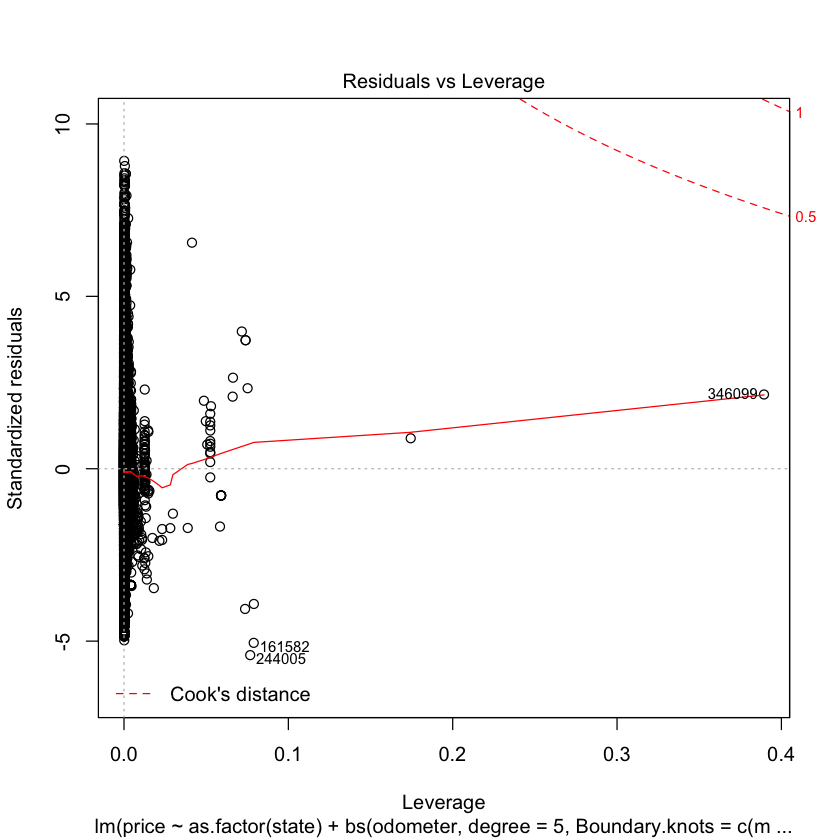

In [17]:
plot(SplineModel)


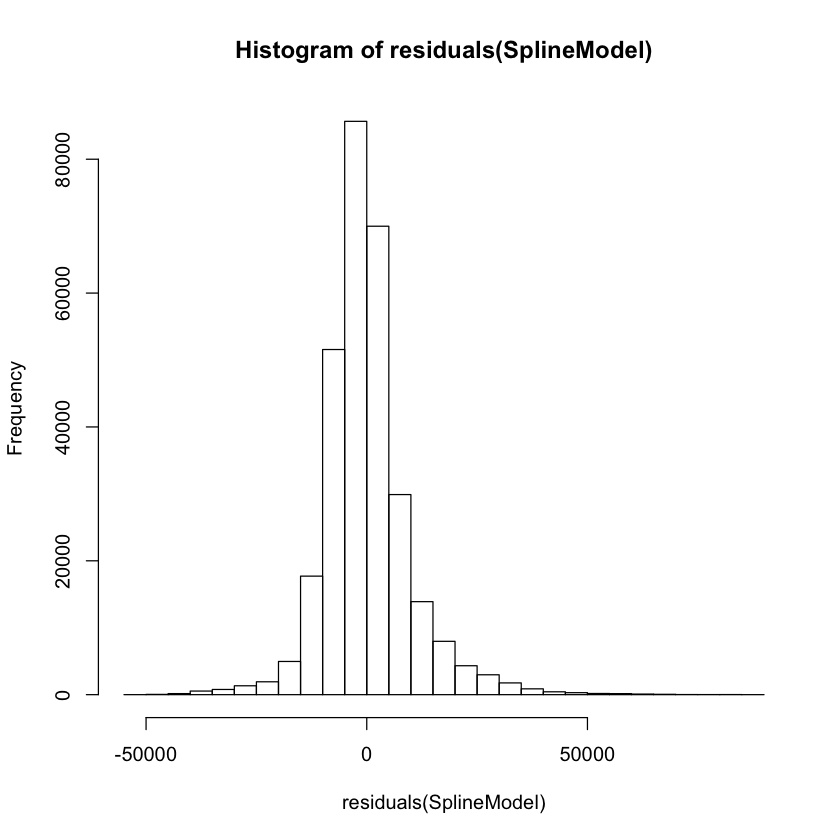

In [18]:
hist(residuals(SplineModel))

### SPLINES REGRESSION MODEL RESULTS
By adding the non-linear component to the covariates using splines, we have met the linearity assumption for the model, however the normality assumption still looks bad on the q-qplot, but looking at the histogram it isn't that bad. The homoscadecity assumption also looks good. The R-squared has improved drastically from 30 to 53 approximately by using splines. But still our model is giving negative predictions, which is a cause of concern. One solution to this is using poisson or Quasi-Poisson regression  with splines so that negative part is removed from predictions. However, this isn't part of the course, so I wont be using it.

## BUILDING A TREE REGRESSION MODEL
Now that we have a sense of direction of which covariates to use we can try using the same covariates that lead to an increased R-squared value in the basic model to build a Tree regression model. 

In [19]:
R2<-numeric(10)
o=1
for(i in seq(0.00001,0.01,0.001)){
tree<-rpart(price ~ type + condition+ odometer+manufacturer, method="anova", 
             data=train,control = rpart.control(cp=i,maxdepth=10,xval = 3))
prediction<-predict(tree,test)
R2[o] <- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
    o<-o+1
}




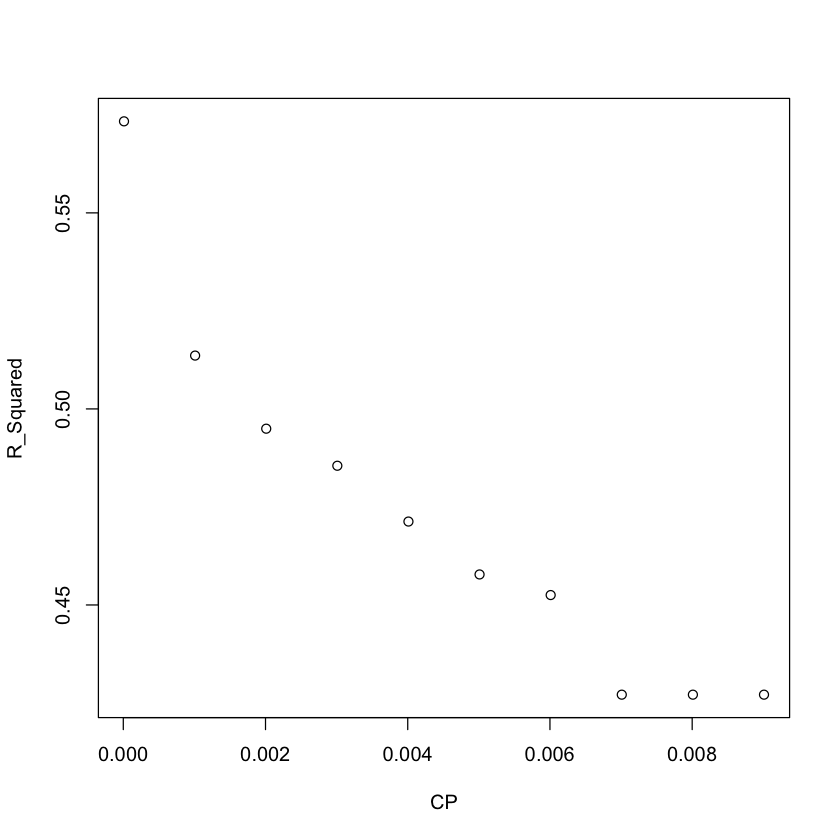

In [20]:
plot(seq(0.00001,0.01,0.001),R2, xlab="CP", ylab= "R_Squared")

I've first looked for a model complexity that increases the R squared value. This model is a little better, we are able to explain approximately 56% of the variation in our data with just four covariates. We can now adjust the max depth to increase accuracy.

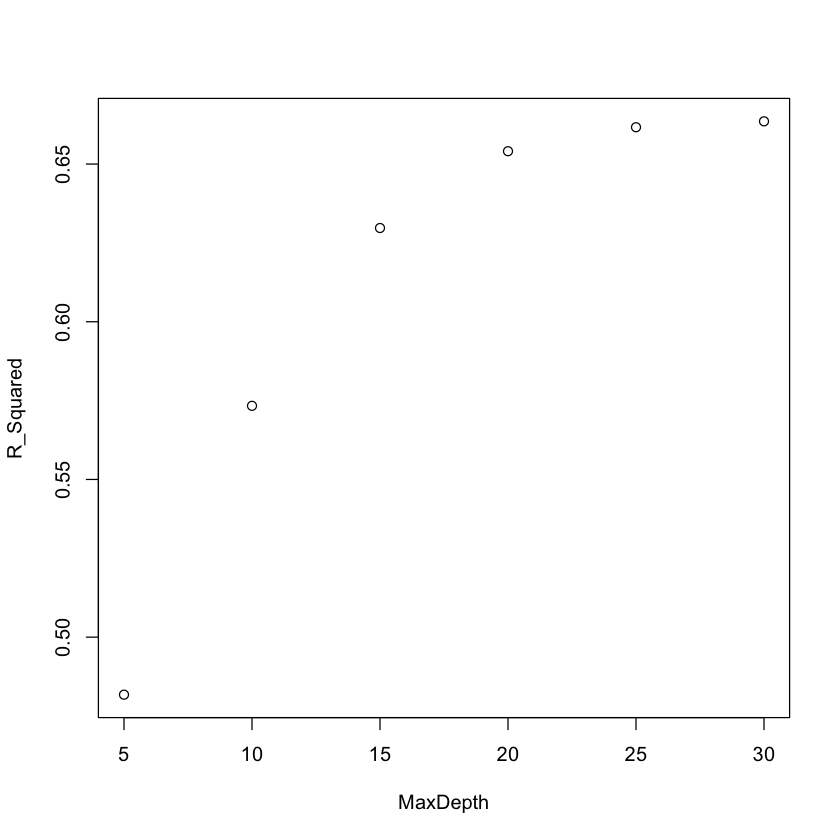

In [21]:
R2<-numeric(6)
o=1
for(i in seq(5,30,5)){
tree<-rpart(price ~ type + condition+ odometer+manufacturer, method="anova", 
             data=train,control = rpart.control(cp=0.00001,maxdepth=i,xval = 3))
prediction<-predict(tree,test)
R2[o] <- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
    o<-o+1
}
plot(seq(5,30,5),R2, xlab="MaxDepth", ylab= "R_Squared")



We can see that beyond depth of 20 trees the R-squared value isn't increasing, however the R-squared value of this model at the moment indicates it approximately explains 67% of the variance. To improve that, we can further lower the complexity parameter 'cp' to increase the complexity of the model and get an even better fit.


[1] 0.6540721

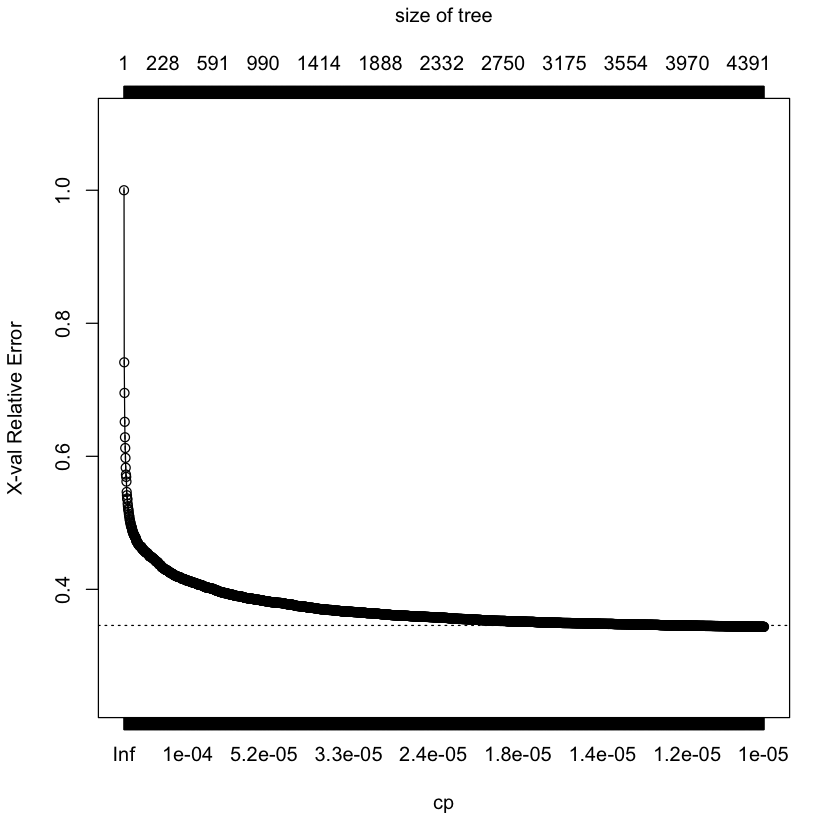

In [22]:
tree<-rpart(price ~ type + condition+ odometer+manufacturer, method="anova", 
             data=train,control = rpart.control(cp=0.00001,maxdepth=20,xval = 10))
prediction<-predict(tree,test)
R2<- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
R2
plotcp(tree)

### TREE MODEL RESULT WITH MANUFACTURER COVARIATE
As we can see, beyond 1.5e-05 the relative error is within the 1 std deviation of error, therefore we can choose that. The accuracy is 66% approximately which is good.

In [23]:
tree<-rpart(price ~ type + condition+ odometer+manufacturer, method="anova", 
             data=train,control = rpart.control(cp=1.5e-05,maxdepth=20,xval = 10))
prediction<-predict(tree,test)
R2<- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
R2

[1] 0.647554

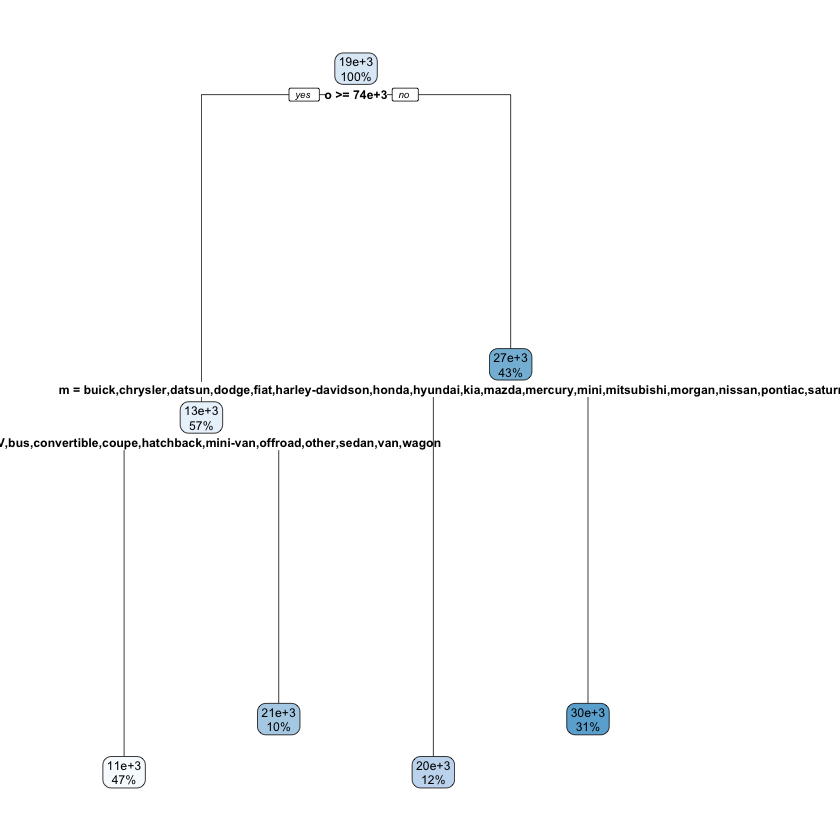

In [24]:
rpart.plot(clip.rpart(tree,best=4),varlen=-1)

As it is a very long tree, we can not interpret or visualize the whole tree. So, i've clipped the tree to explain it a bit. At the root node it divides the regions based on the odometer value >= 74000KM, the groups in these regions are predicted to have the same price $13000 (o >= 74K) and $27000 (o < 74K). The left branch is then divided based on car types, the cars of the type bus, convertible, coupe , hatchback, minivan other, sedan, can and wagon have are predicted as $11000 price and not belonging to one of these types are given $21000 as prediction. The right branch is divded further based on manufacturers (buick,chrysler,datsun,dodge,fiat,harley-davidson,honda,hyundai,kia,landrover,mazda,mercury,mini,mitsubishi,morgan,nissan,pontiac), those having one of this manufacturer is given $20000 as prediction, $30000 to ones not belonging to these.



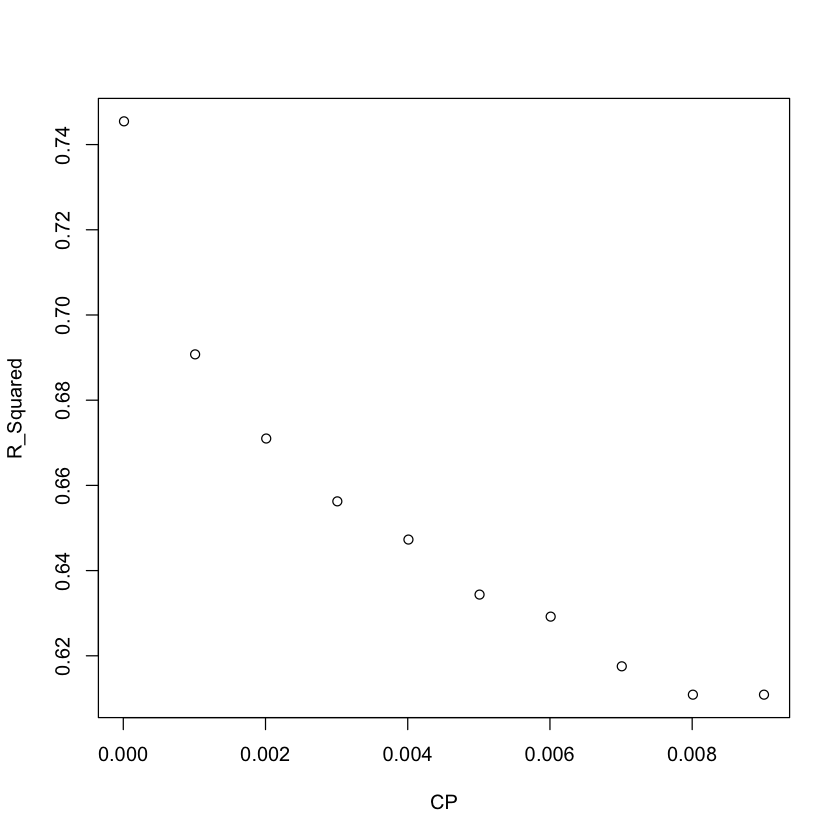

In [25]:
R2<-numeric(10)
o=1

for(i in seq(0.00001,0.01,0.001)){
tree<-rpart(price ~ type + condition+ odometer+model, method="anova", 
             data=train,control = rpart.control(cp=i,maxdepth=10,xval = 10))
prediction<-predict(tree,test)
R2[o] <- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
o<-o+1
}
plot(seq(0.00001,0.01,0.001),R2, xlab="CP", ylab= "R_Squared")

I was avoiding the addition of the 'model' covariate as it has a lot of categories, means more parameters and the complexity is therefore increased. The dataset was extremely large and computing linear model using it was causing speed issues. It also hinders interpretability of the model as plot including this covariate isn't possible. But adding it to the model tree model has increased the R squared value (74%), the amount of variance explained by the model. Therefore, I've added this at the end after explaining everything using other models. 

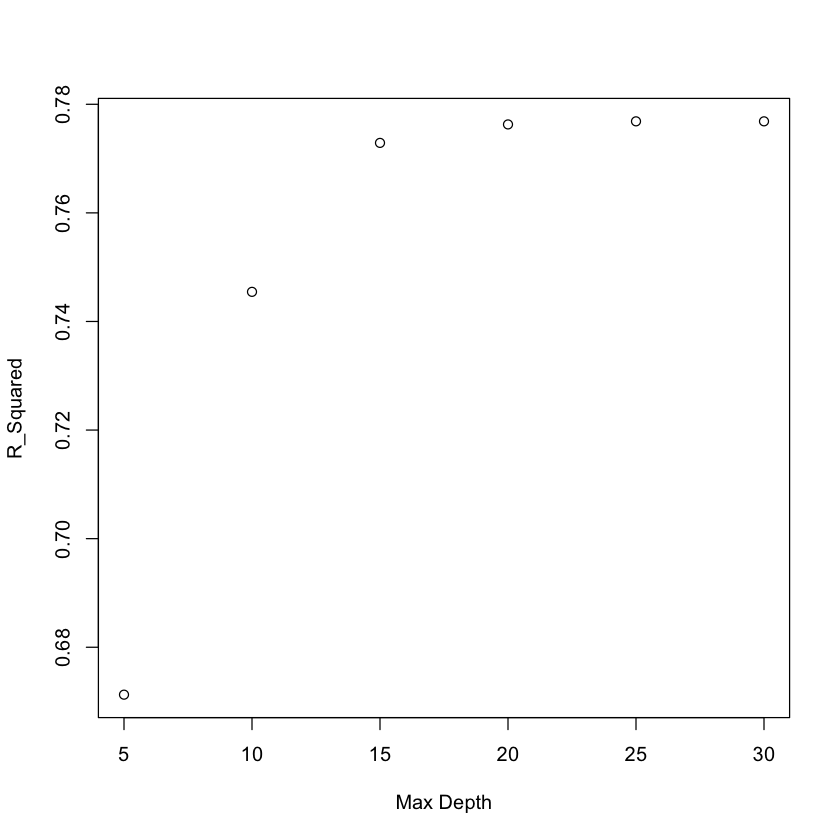

In [26]:
R2<-numeric(6)
o=1
for(i in seq(5,30,5)){
tree<-rpart(price ~ type + condition+ odometer+model, method="anova", 
             data=train,control = rpart.control(cp=0.00001,maxdepth=i,xval = 3))
prediction<-predict(tree,test)
R2[o] <- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
o<-o+1
}
plot(seq(5,30,5),R2, xlab="Max Depth", ylab= "R_Squared")

After 20 trees there isn't any increase in the model's ability to explain the variance (77% R2 value), therefore we'll keep the max depth to 20 trees.

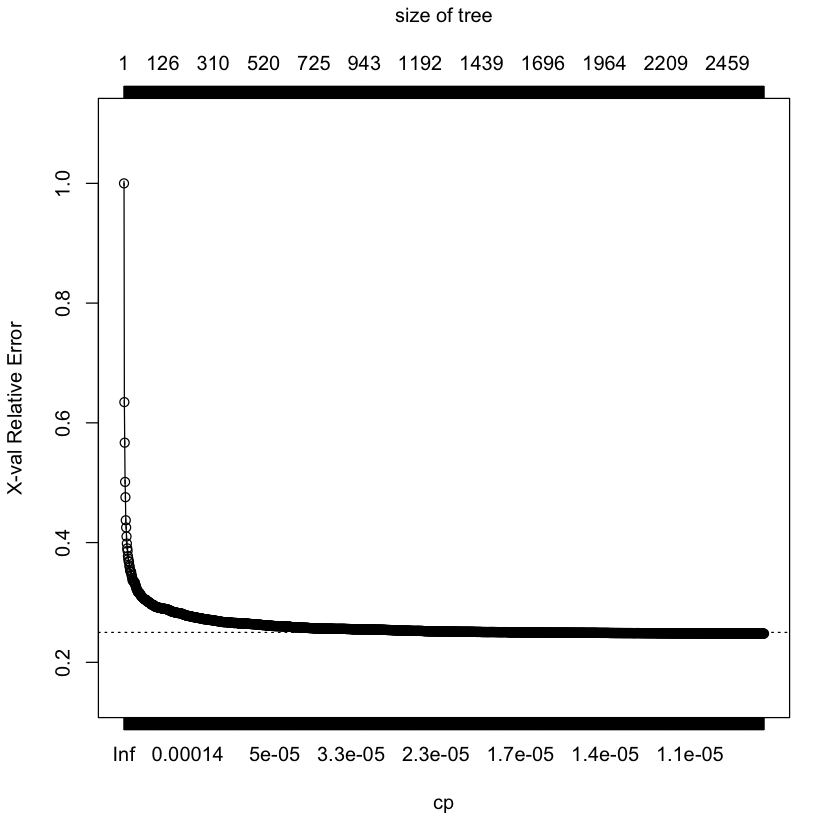

In [27]:
tree<-rpart(price ~ type + condition+ odometer+model, method="anova", 
             data=train,control = rpart.control(cp=0.00001,maxdepth=20,xval = 3))
plotcp(tree)

In [28]:
tree<-rpart(price ~ type + condition+ odometer+model, method="anova", 
             data=train,control = rpart.control(cp=3.3e-5,maxdepth=20,xval = 3))
prediction<-predict(tree,test)
R2<- 1 - (sum((test$price-prediction)^2)/sum((test$price-mean(test$price))^2))
R2

[1] 0.7638377

### TREE MODEL RESULT WITH MODEL COVARIATE INSTEAD OF MANUFACTURER
We are now getting an R2 value of about 76% with some tuning of the cp parameter, which is quite good considering we are using only 4 covariates. The interpretability of the model isn't possible.
